In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

dataset3 = pd.read_csv("tourist_attractions_ireland_full_2.csv")

np.random.seed(42) 
num_users = 200  

user_ratings = []

for attraction_id in range(len(dataset3)):
    num_ratings = np.random.randint(1, 10)  
    for _ in range(num_ratings):
        user_id = np.random.randint(1, num_users + 1)
        rating = np.clip(np.random.normal(loc=3.5, scale=1.0), 1, 5) 
        user_ratings.append({
            'User_ID': user_id,
            'Attraction': dataset3['Name'][attraction_id],
            'User_Rating': rating
        })

user_ratings_df = pd.DataFrame(user_ratings)

simulated_ratings_file_path = "tourist_data_with_ratings_dataset3.csv"
user_ratings_df.to_csv(simulated_ratings_file_path, index=False)

tags_vectorizer = TfidfVectorizer(stop_words='english')
tags_tfidf_matrix = tags_vectorizer.fit_transform(dataset3['Tags'].fillna(''))

n_components = min(tags_tfidf_matrix.shape[1], 35)  
svd = TruncatedSVD(n_components=n_components, random_state=42)
tags_tfidf_reduced = svd.fit_transform(tags_tfidf_matrix)

item_similarity = cosine_similarity(tags_tfidf_reduced)

attractions = dataset3['Name'].tolist()
user_ratings_matrix = pd.pivot_table(user_ratings_df, values='User_Rating', index='User_ID', columns='Attraction', fill_value=0)
user_ratings_matrix = user_ratings_matrix.reindex(columns=attractions, fill_value=0).to_numpy()

predicted_ratings = user_ratings_matrix.copy()  # Copy the user ratings for predictions

def train_knn_and_predict(X, user_ratings, n_neighbors=5):
    observed_indices = np.where(user_ratings > 0)[0]
    missing_indices = np.where(user_ratings == 0)[0]

    if len(observed_indices) == 0:
        return np.zeros(len(user_ratings))

    X_train, X_test, y_train, y_test = train_test_split(
        X[observed_indices], user_ratings[observed_indices], test_size=0.2, random_state=42
    )

    
    knn = KNeighborsRegressor(n_neighbors=n_neighbors, metric="cosine")
    knn.fit(X_train, y_train)

    
    y_pred_test = knn.predict(X_test)
    mse = mean_squared_error(y_test, y_pred_test)
    print(f"User MSE: {mse}")

    full_predictions = knn.predict(X)
    return full_predictions

for user_idx in range(user_ratings_matrix.shape[0]):
    print(f"Processing User {user_idx + 1}/{user_ratings_matrix.shape[0]}")
    user_ratings = user_ratings_matrix[user_idx]
    predicted_ratings[user_idx] = train_knn_and_predict(tags_tfidf_reduced, user_ratings)

predicted_ratings_df = pd.DataFrame(predicted_ratings, index=user_ratings_df['User_ID'].unique(), columns=attractions)

predicted_ratings_file_path = "predicted_user_ratings_dataset3.csv"
predicted_ratings_df.to_csv(predicted_ratings_file_path)

true_ratings = []
pred_ratings = []

for user_idx in range(user_ratings_matrix.shape[0]):
    observed_indices = np.where(user_ratings_matrix[user_idx] > 0)[0]
    true_ratings.extend(user_ratings_matrix[user_idx][observed_indices])
    pred_ratings.extend(predicted_ratings[user_idx][observed_indices])

rmse = np.sqrt(mean_squared_error(true_ratings, pred_ratings))
mae = mean_absolute_error(true_ratings, pred_ratings)
r2 = r2_score(true_ratings, pred_ratings)

print("Evaluation Metrics:")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

# Generating Recommendations to test
def recommend_items(user_index, user_ratings, similarity_matrix, top_n=5):
    user_sim_scores = similarity_matrix.dot(user_ratings)
    norm_sim_scores = user_sim_scores / np.array([np.abs(similarity_matrix).sum(axis=1)]).T.flatten()
    recommended_indices = np.argsort(-norm_sim_scores)[:top_n]
    return recommended_indices

user_index = 0
user_ratings = predicted_ratings[user_index]
top_recommendations = recommend_items(user_index, user_ratings, item_similarity, top_n=5)

recommended_items = dataset3.iloc[top_recommendations][['Name', 'Rating', 'Tags']]
print(recommended_items.reset_index(drop=True))


Processing User 1/200
User MSE: 0.8148785418368677
Processing User 2/200
User MSE: 0.9014080141734832
Processing User 3/200
User MSE: 1.3647193305612935
Processing User 4/200
User MSE: 1.2621203147003963
Processing User 5/200
User MSE: 1.0308773170939138
Processing User 6/200
User MSE: 2.037910728171704
Processing User 7/200
User MSE: 0.6565603256119226
Processing User 8/200
User MSE: 0.5399746336135097
Processing User 9/200
User MSE: 0.4681927174392629
Processing User 10/200
User MSE: 1.302147122162768
Processing User 11/200
User MSE: 0.544183000763575
Processing User 12/200
User MSE: 0.8248418624764732
Processing User 13/200
User MSE: 0.34366034157206216
Processing User 14/200
User MSE: 0.40132146493165594
Processing User 15/200
User MSE: 1.6522112702842604
Processing User 16/200
User MSE: 0.2824700540048671
Processing User 17/200
User MSE: 1.3128621820189672
Processing User 18/200
User MSE: 0.3898230450911706
Processing User 19/200
User MSE: 0.5779477258049147
Processing User 20/200

Processing User 167/200
User MSE: 0.3461867772083096
Processing User 168/200
User MSE: 0.6056879123158362
Processing User 169/200
User MSE: 0.5068598944149566
Processing User 170/200
User MSE: 0.5790884178522736
Processing User 171/200
User MSE: 0.9646409667652466
Processing User 172/200
User MSE: 1.2155207495114602
Processing User 173/200
User MSE: 0.7019320190328187
Processing User 174/200
User MSE: 0.49349867201631337
Processing User 175/200
User MSE: 0.8709051853417858
Processing User 176/200
User MSE: 0.5971985396996549
Processing User 177/200
User MSE: 0.7893886164896099
Processing User 178/200
User MSE: 0.5002325062532292
Processing User 179/200
User MSE: 0.2635239675085589
Processing User 180/200
User MSE: 1.1709581711160895
Processing User 181/200
User MSE: 0.058766722910517134
Processing User 182/200
User MSE: 1.5658498851358638
Processing User 183/200
User MSE: 0.8366518962368835
Processing User 184/200
User MSE: 0.5332388543833794
Processing User 185/200
User MSE: 0.7515056

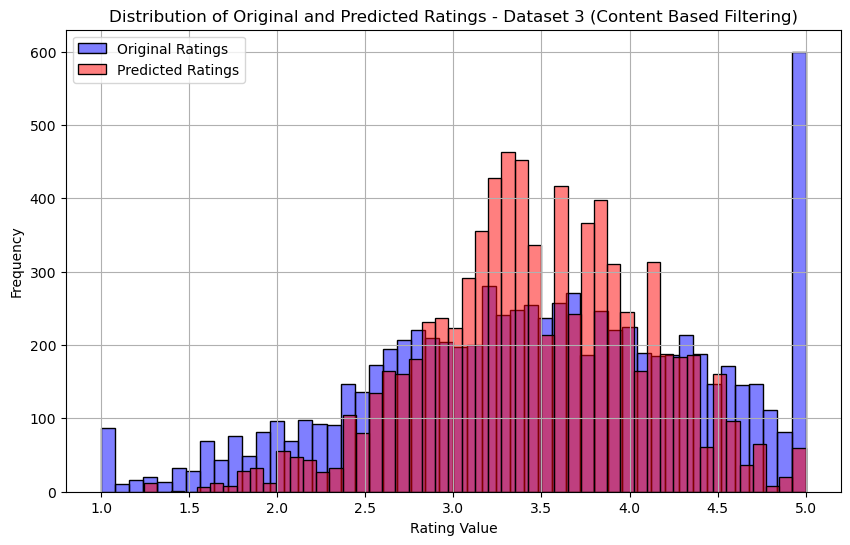

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(true_ratings, bins=50, color='blue', alpha=0.5, label='Original Ratings')
sns.histplot(pred_ratings, bins=50, color='red', alpha=0.5, label='Predicted Ratings')
plt.xlabel('Rating Value')
plt.ylabel('Frequency')
plt.title('Distribution of Original and Predicted Ratings - Dataset 3 (Content Based Filtering)')
plt.legend()
plt.grid(True)
plt.show()
